<a href="https://colab.research.google.com/github/Vonewman/Hugginface-course/blob/main/Classifier_des_Tweets_avec_%F0%9F%A4%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 7.1 MB/s 
     |████████████████████████████████| 72 kB 1.8 MB/s 
     |████████████████████████████████| 5.5 MB 64.1 MB/s 
     |████████████████████████████████| 212 kB 68.6 MB/s 
     |████████████████████████████████| 95 kB 6.0 MB/s 
     |████████████████████████████████| 163 kB 54.6 MB/s 
     |████████████████████████████████| 115 kB 67.4 MB/s 
     |████████████████████████████████| 127 kB 72.9 MB/s 
     |████████████████████████████████| 115 kB 63.7 MB/s 
     |████████████████████████████████| 7.6 MB 49.4 MB/s 
     |████████████████████████████████| 1.3 MB 45.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      S

# Text Classification

Scenario: Imaginez maintenant que vous êtes un datascientist qui a besoin de construire un système qui peut auto‐identifier automatiquement les états émotionnels tels que la « colère » ou la « joie » que les gens expriment à propos du produit de votre entreprise sur Twitter. Dans ce notebook nous aborderons cette tâche à l'aide d'un variant de BERT appelé DistilBERT.

### Dataset de HuggingFace

In [ ]:
from datasets import list_datasets

all_datasets = list_datasets()

print(f"Il y a {len(all_datasets)} ensembles de données actuellement disponibles sur le Hub")
print(f"Les 10 premiers sont: {all_datasets[:10]}")

Il y a 13680 ensembles de données actuellement disponibles sur le Hub
Les 10 premiers sont: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


Nous voyons que chaque ensemble de données reçoit un nom, chargeons donc le dataset `emotion` avec la fonction `load_dataset()` :

In [ ]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
len(train_ds)

16000

In [ ]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
train_ds.column_names

['text', 'label']

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [ ]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


## Que faire si mon jeu de données n'est pas sur le hub ?

In [ ]:
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
!wget {dataset_url}

--2022-11-12 19:48:49--  https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/1pzkadrvffbqw6o/train.txt [following]
--2022-11-12 19:48:49--  https://www.dropbox.com/s/raw/1pzkadrvffbqw6o/train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5c58ec3c9bcec3a989ec16d021.dl.dropboxusercontent.com/cd/0/inline/BwogrgyEg6SpjJve7WH6q8kRCLzY1eXA10qB-hPFwOxoyWeXsd0Z-w-E-tEPeWA8ZnHd_j2vsCPxvh9LOiur48Ur0PMTcwHKMG9-l5NEz75YntY3z5XzRK6pl0RMGUa9vZjMGEg9Lhk6R0Syxy91HiRplDWr55CQevi_p91Kch36MA/file# [following]
--2022-11-12 19:48:49--  https://uc5c58ec3c9bcec3a989ec16d021.dl.dropboxusercontent.com/cd/0/inline/BwogrgyEg6SpjJve7WH6q8kRCLzY1eXA10qB-hPFwOxoyWeXsd0Z-w-E-tEPeWA8ZnHd_j2vsCPxvh9LOiur48Ur0

In [ ]:
!head -n 5 train.txt

i didnt feel humiliated;sadness
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness
im grabbing a minute to post i feel greedy wrong;anger
i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love
i am feeling grouchy;anger


In [ ]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", names=["text", "label"]) # pour telecharger les donnees locales
# load_dataset("text", data_files="my_file.txt") # format text
# load_dataset("json", data_files="my_file.json") # format json

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-b462c3dbe7eed2d2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Une methode plus simple et plus rapide
# utiliser l'url ou se trouve le dataset
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";",
names=["text", "label"])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a70389bc6b0a03f2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
emotions_remote_train = emotions_remote["train"]

In [ ]:
emotions_remote_train['label']

['sadness',
 'sadness',
 'anger',
 'love',
 'anger',
 'sadness',
 'surprise',
 'fear',
 'joy',
 'love',
 'sadness',
 'joy',
 'anger',
 'sadness',
 'joy',
 'joy',
 'sadness',
 'sadness',
 'sadness',
 'fear',
 'anger',
 'fear',
 'joy',
 'joy',
 'anger',
 'sadness',
 'sadness',
 'sadness',
 'anger',
 'joy',
 'joy',
 'fear',
 'surprise',
 'anger',
 'joy',
 'joy',
 'joy',
 'joy',
 'anger',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'sadness',
 'sadness',
 'joy',
 'love',
 'joy',
 'anger',
 'joy',
 'sadness',
 'anger',
 'fear',
 'joy',
 'sadness',
 'sadness',
 'surprise',
 'joy',
 'joy',
 'joy',
 'love',
 'fear',
 'fear',
 'surprise',
 'anger',
 'anger',
 'sadness',
 'love',
 'joy',
 'sadness',
 'sadness',
 'joy',
 'sadness',
 'sadness',
 'sadness',
 'joy',
 'joy',
 'joy',
 'anger',
 'sadness',
 'anger',
 'anger',
 'anger',
 'joy',
 'joy',
 'joy',
 'joy',
 'sadness',
 'fear',
 'love',
 'anger',
 'sadness',
 'anger',
 'love',
 'sadness',
 'joy',
 'joy',
 'sadness',
 'anger',
 'love',
 'joy',
 '

## From  🤗 Datasets to DataFrames

 🤗 Dataset fournit la méthode `set_format()` pour changer le format de donnees dans notre dataset. Dans notre cas on va le transformer en DataFrame Pandas pour faciliter la visualization.

In [ ]:
import pandas as pd

emotions.set_format(type="pandas") # change le format de l'output
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
emotions["train"].features["label"].int2str

<bound method ClassLabel.int2str of ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)>

In [ ]:
def label_int2str(row):
    """Cree une nouvelle colonne pour representer les sentiments."""
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Visualisons nos donnees

### Examinons la répartition des classes

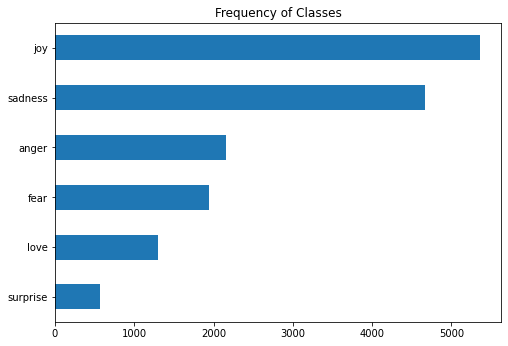

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,5.5) # Pour augumenter la taille du plot

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

## Visualisons la longueur des Tweets

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


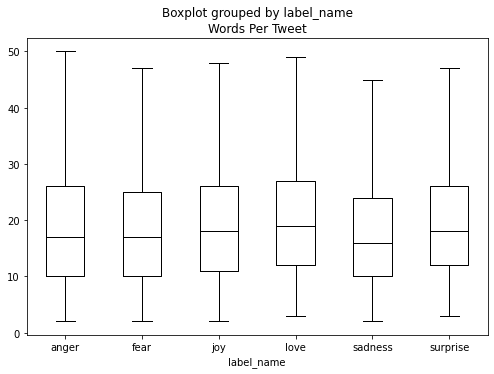

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
           showfliers=False, color="black")

In [ ]:
emotions.reset_format()  # retrouver le type de 🤗 Dataset

## Du texte au token

### Tokenizer basé sur les caractères

In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


Assigner a chaque caractere un id unique

In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [ ]:
categorical_df = pd.DataFrame(
 {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [ ]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [ ]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [ ]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## Tokenization des mots

Au lieu de diviser le texte en caractères, nous pouvons le diviser en mots et mapper chacun
mot à un entier. L'utilisation de mots dès le départ permet au modèle de sauter l'étape de
apprendre des mots à partir de caractères, et ainsi réduire la complexité de la formation
traiter.

In [ ]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


## Tokenization en sous-mots

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [ ]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.model_max_length

512

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

## Tokenizer l'ensemble du dataset

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Entrainer un Classificateur de Text

### Transformers as Feature Extractors

In [ ]:
# Using pretrained models
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Extracting the last hidden states

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
    if k in tokenizer.model_input_names}
        # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating a feature matrix

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualizing the training set

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.4 MB/s 
     |████████████████████████████████| 1.1 MB 49.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=c9e3e94b4640f043e262963e7163fb548d5fe2eee4946233742b2412656a0748
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=541d805711cf6f02c04e88890a16b3423978cf27aa258c0edbc85b738fc98da8
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.888238,6.939536,0
1,-2.656892,6.464424,0
2,5.199820,3.334998,3
3,-2.117131,4.150665,2
4,-3.057988,4.519480,3


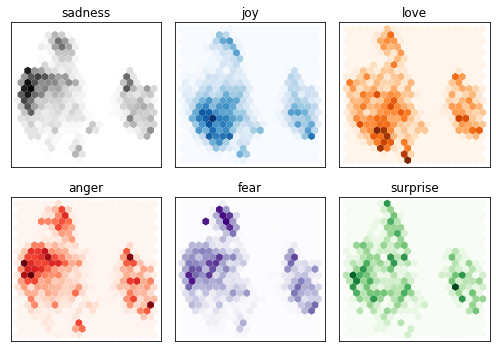

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Training a simple classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

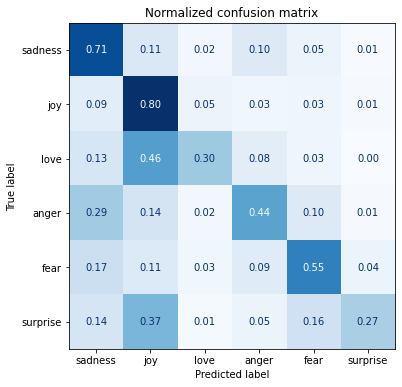

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine-tuning Transformers

### Loading a pre-trained model

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

### Defining the performance metric

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### Training the model

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train();

/usr/local/lib/python3.7/dist-packages/huggingface_hub/repository.py:708: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  FutureWarning,
Cloning https://huggingface.co/vonewman/distilbert-base-uncased-finetuned-emotion into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.809400,0.315750,0.905500,0.900887
2,0.246200,0.221684,0.921000,0.921211


In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

{'test_loss': 0.22168444097042084,
 'test_accuracy': 0.921,
 'test_f1': 0.9212108560221193,
 'test_runtime': 5.4854,
 'test_samples_per_second': 364.601,
 'test_steps_per_second': 5.834}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

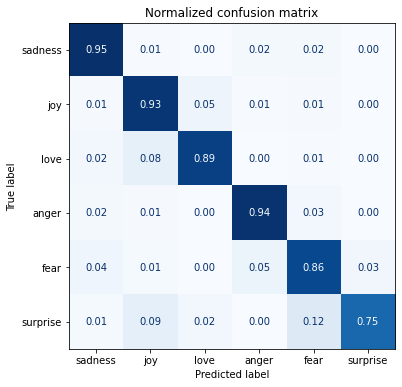

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

### Error analysis

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1274,i am going to several holiday parties and i ca...,joy,sadness,5.660124
882,i feel badly about reneging on my commitment t...,love,sadness,5.441643
765,i feel super awkward and out of place right now,joy,sadness,5.422346
465,i would eventually go in to these stores but i...,joy,fear,5.297482
1950,i as representative of everything thats wrong ...,surprise,sadness,5.228998
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.178849
1963,i called myself pro life and voted for perry w...,joy,sadness,5.131258
1509,i guess this is a memoir so it feels like that...,joy,fear,5.076793
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.915456
1801,i feel that he was being overshadowed by the s...,love,sadness,4.904990


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1618,i had a good feeling about the presentation an...,joy,joy,0.016946
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.016978
69,i have no extra money im worried all of the ti...,sadness,sadness,0.017014
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.017242
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.017289
697,i was missing him desperately and feeling idio...,sadness,sadness,0.017295
1154,i love feeling carefree and without all these ...,joy,joy,0.017332
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.017440
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.017458
189,i leave the meeting feeling more than a little...,sadness,sadness,0.017510


### Saving and sharing the model

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Nov12_21-50-04_b2e1fe23d629/events.out.tfevents.1668289858.b2e1fe23d629.79.0:  64%|######4   …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/vonewman/distilbert-base-uncased-finetuned-emotion
   7227c33..9e1c4c3  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/vonewman/distilbert-base-uncased-finetuned-emotion
   7227c33..9e1c4c3  main -> main

To https://huggingface.co/vonewman/distilbert-base-uncased-finetuned-emotion
   9e1c4c3..aae9ff2  main -> main

   9e1c4c3..aae9ff2  main -> main



'https://huggingface.co/vonewman/distilbert-base-uncased-finetuned-emotion/commit/9e1c4c30d71db6a5e30a9af84aaca3ae40091f04'

In [ ]:
from transformers import pipeline

model_id = "vonewman/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:92: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  UserWarning,


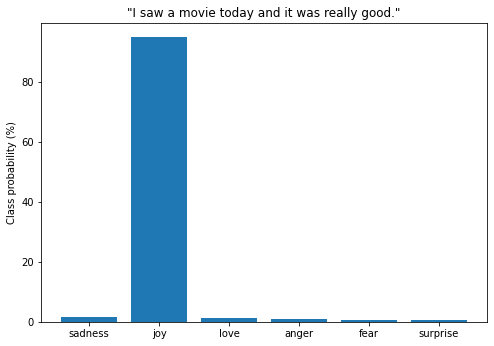

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()